veri setimiz: Teslanın günlük hisse senedi verileri

In [216]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#modeldegerlendirme ve veriyi  scale edebilmemiz için kullanılacak oaln kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings 
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [217]:
df= pd.read_csv("TSLA.csv")

In [218]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [219]:
def check_df(dataframe, head=5):
    print("#############SHAPE############")
    print(dataframe.shape)
    print("#############TYPES############")
    print(dataframe.dtypes)
    print("#############HEAD#############")
    print(dataframe.head(head))
    print("#############NA###############")
    print(dataframe.isnull().sum())
    print("#############QUANTILES########")
    
    # Sadece sayısal sütunları seçiyoruz
    numeric_cols = dataframe.select_dtypes(include=['number']).columns
    
    # Sayısal verilere quantile fonksiyonunu uyguluyoruz
    print(dataframe[numeric_cols].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [220]:
check_df(df)

#############SHAPE############
(2416, 7)
#############TYPES############
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
#############HEAD#############
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
#############NA###############
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
#############QUANTILES########
                    0.00           0.05          0.50          0.95  \
Open           16.139999      23.38

date degisikeni object oalrak gozüküyor onu tarihe çeviricez

In [221]:
df["Date"] = pd.to_datetime(df["Date"])

In [222]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [223]:
tesla_df = df[["Date", "Close"]]

In [224]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [225]:
print("Min tatih:", tesla_df["Date"].min())
print("Max tatih:", tesla_df["Date"].max())

Min tatih: 2010-06-29 00:00:00
Max tatih: 2020-02-03 00:00:00


date bilgisiyni idex'e yerlestireecez

In [226]:
tesla_df.index = tesla_df["Date"]

In [227]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [228]:
tesla_df.drop("Date", axis=1, inplace=True)

In [229]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [230]:
result_df = tesla_df.copy() # ilerde result_df lazim olcaktir

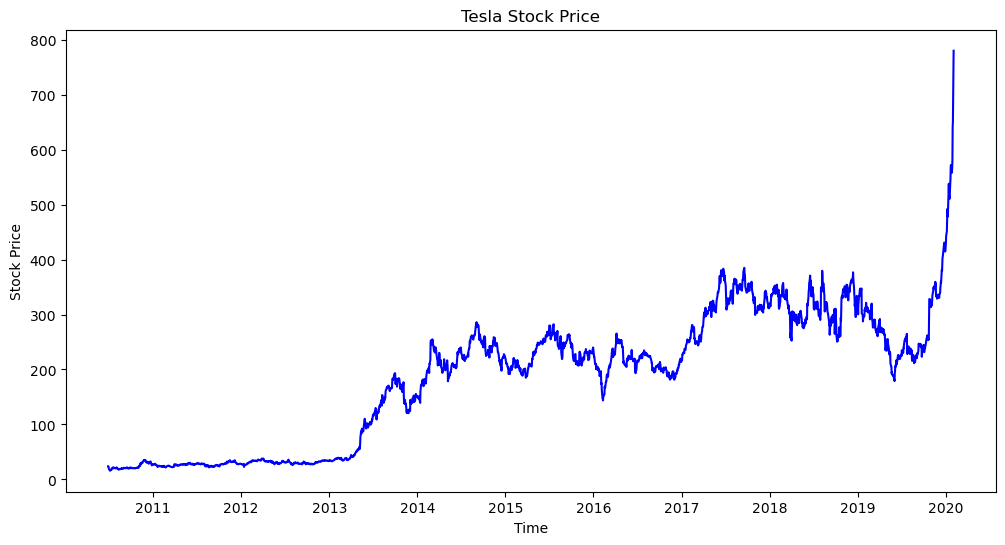

In [231]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df["Close"], color = 'blue')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

In [232]:
tesla_df = tesla_df.values

In [233]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [234]:
print(tesla_df.dtype)

float64


In [235]:
tesla_df = tesla_df.astype('float32')

In [236]:
print(tesla_df.dtype)

float32


tran-test splite

In [237]:
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [238]:
train, test, pos = split_data(tesla_df, 0.20)

In [239]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [240]:
scaler_train = MinMaxScaler(feature_range= (0,1))
train = scaler_train.fit_transform(train)
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [241]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [242]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [243]:
def create_features(data, lookback):
    x,y = [], []
    for i in range(lookback, len(data)):
        x.append(data[i-lookback:i,0])
        y.append(data[i,0])
    return np.array(x), np.array(y)

In [244]:
lookback = 20

In [245]:
x_train, y_train = create_features(train, lookback)
x_test, y_test = create_features(test, lookback)

In [246]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [247]:
x_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

veri 3D olamsi gerekiyor reshape ile ayarlicaz

In [248]:
print("Before reshaping:")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Before reshaping:
(1913, 20)
(463, 20)
(1913,)
(463,)


In [249]:
# x_train ve x_test'in yeniden şekillendirilmesi
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))  # (1913, 1, 20)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))      # (463, 1, 20)

# y_train ve y_test'in yeniden şekillendirilmesi
y_train = y_train.reshape(-1, 1)  # (1913, 1)
y_test = y_test.reshape(-1, 1)    # (463, 1)


reshapede ekeldiğimiz "1" zaman adımı anlamına geliyor. 1 zamanadımına ihtiyacımız var.
7 yazsak 7 zaman adimi olucak mesela

In [250]:
print("After reshaping:")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape) 

After reshaping:
(1913, 1, 20)
(463, 1, 20)
(1913, 1)
(463, 1)


Modelleme

In [251]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1)) # çıkış katmanıma 1 tane nörün ekledim

In [252]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

Optimizasyon ve Değerlendirme Metrkiklerin ayrlanilmasi

In [253]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [254]:
callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"), ModelCheckpoint(filepath='mymodel.keras', monitor = 'val_loss', mode = 'min', save_best_only=True, save_weights_only=False, verbose=1)]

In [255]:
history = model.fit(x=x_train, 
                    y= y_train, 
                    epochs=100, 
                    batch_size=20, 
                    validation_data=(x_test, y_test),
                    callbacks=callbacks, 
                    shuffle=False)

Epoch 1/100
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 
Epoch 1: val_loss improved from inf to 0.00414, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 2/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 2: val_loss improved from 0.00414 to 0.00346, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 3/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 3: val_loss improved from 0.00346 to 0.00337, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/100
88/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 4: val_loss improved from 0.00337 to 0.00308, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/100
87/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 5: val_loss did not improve from 0.00308
96/96

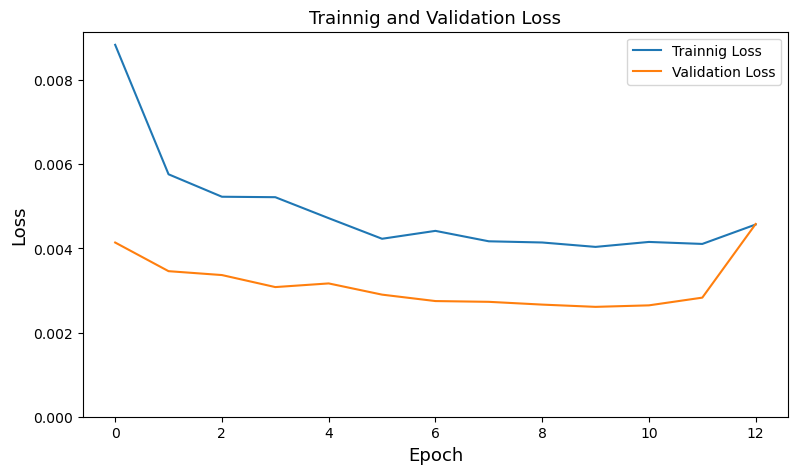

In [256]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Trainnig Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch', fontsize= 13)
plt.ylabel('Loss', fontsize= 13)
plt.ylim([0, max(plt.ylim())])
plt.title('Trainnig and Validation Loss', fontsize= 13)
plt.show()

Değerlendirme(Evulation)

In [257]:
loss= model.evaluate(x_test, y_test, batch_size=1)
print("n\Test loss: %.1f%%"%(100.0 * loss))

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047
n\Test loss: 0.5%


In [258]:
train_predict = model.predict(x_train)
test_predict= model.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


scaler ile standartlaştirama ile geriye doğru götürüyoruz

In [259]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [260]:
y_train = scaler_train.inverse_transform(y_train)
y_test= scaler_test.inverse_transform(y_test)

In [261]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:18.19205665588379
Test RMSE:40.68373489379883


In [262]:
train_predict_df = result_df[lookback:pos]
train_predict_df["Predicted"] = train_predict
train_predict_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,39.846859
2010-07-29,20.350000,39.825687
2010-07-30,19.940001,39.810673
2010-08-02,20.920000,39.771015
2010-08-03,21.950001,39.768234


In [264]:
test_predict_df = result_df[pos + lookback:]
test_predict_df["Predicted"] = test_predict
test_predict_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,337.450714
2018-04-04,286.940002,334.117310
2018-04-05,305.720001,333.283966
2018-04-06,299.299988,332.103851
2018-04-09,289.660004,331.697021


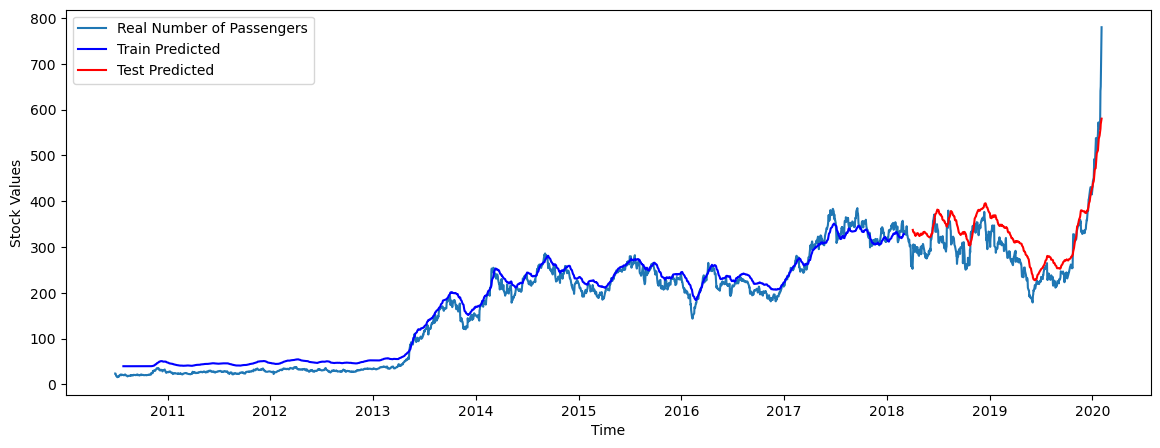

In [265]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label='Real Number of Passengers')
plt.plot(train_predict_df["Predicted"], color='blue', label= 'Train Predicted')
plt.plot(test_predict_df["Predicted"], color='red', label= 'Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()